<a href="https://colab.research.google.com/github/kanakesh2006/Langgraph_for_Agentic_AI_Concepts/blob/main/Conditional%20Workflows/review_reply_llm_conditional_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain langgraph langchain_google_genai langchain_groq langchain_community transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.1/719.1 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.9/234.9 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.43.0
    Uninstalling google-auth-2.43.0:
 

In [1]:
import os
from google.colab import userdata

# os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')


# using  GROQ's  "llama-3.1-8b-instant"  model
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')


# os.environ['HUGGINGFACE_API_KEY'] = userdata.get('HUGGINGFACE_API_KEY')


In [5]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq
from typing import TypedDict, Annotated, Literal
from pydantic import BaseModel, Field
import operator

In [4]:
model = ChatGroq(model="llama-3.1-8b-instant")

In [8]:
# structured output


# structure schema
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description = 'Sentiment of the review as either negative or positive')

class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')


# structured model
structured_model = model.with_structured_output(SentimentSchema)

structured_model2 = model.with_structured_output(DiagnosisSchema)


In [7]:
# define state

class ReviewState(TypedDict):

  review: str
  sentiment: Literal['positive', 'negative']
  diagnosis: dict
  response: str


In [31]:
# node functions


def find_sentiment(state: ReviewState):

  prompt = f"""Given the following review, determine if the sentiment is 'positive' or 'negative'.
  Use the SentimentSchema tool to output your answer. Your response must ONLY contain the tool call.

  Review:
  "{state["review"]}"
  """
  sentiment = structured_model.invoke(prompt).sentiment

  return {"sentiment": sentiment}


# condition check function
def check_sentiment(state: ReviewState) -> Literal["positive response", "run diagnosis"]:

  if state["sentiment"] == 'positive':
    return "positive response"
  else:
    return "run diagnosis"


def positive_response(state: ReviewState):

  prompt = prompt = f"""Write a warm thank-you message in response to this review:
\n\n\"{state['review']}\"\n
Also, kindly ask the user to leave feedback on our website.
"""

  response = model.invoke(prompt).content

  return {'response': response}


def run_diagnosis(state: ReviewState):

    prompt = f"""You are an AI assistant tasked with diagnosing negative customer reviews.
    Analyze the following review and extract the issue type, emotional tone, and urgency using the provided DiagnosisSchema.

    Review:
    \"\"\"{state['review']}\"\"\"
"""
    response = structured_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}


def negative_response(state: ReviewState):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content

    return {'response': response}

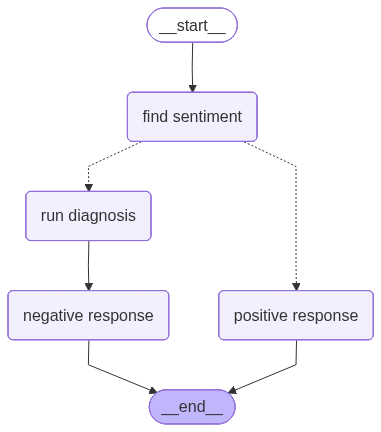

In [32]:
# define graph
graph = StateGraph(ReviewState)

# add nodes
graph.add_node("find sentiment", find_sentiment)
graph.add_node("positive response", positive_response)
graph.add_node("run diagnosis", run_diagnosis)
graph.add_node("negative response", negative_response)

# add edges
graph.add_edge(START, "find sentiment")

graph.add_conditional_edges('find sentiment', check_sentiment)

graph.add_edge("positive response", END)

graph.add_edge("run diagnosis", "negative response")
graph.add_edge("negative response", END)

# compile graph
graph.compile()


In [33]:
workflow = graph.compile()

In [34]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}

workflow.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': "Subject: Re: Urgent: Bug Issue - Resolved\n\nDear [User],\n\nI can sense the frustration in your initial message, and I apologize for the inconvenience caused by the bug issue you're experiencing. Please know that I'm here to help and am committed to resolving this issue as quickly as possible.\n\nAfter reviewing your initial report, I've identified the possible cause of the problem and have implemented a fix. To confirm, I've replicated the issue on our end and have successfully resolved it.\n\nTo ensure that the issue is completely resolved, I recommend the following steps:\n\n1. Restart your application/device to ensure that a